```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital

This notebook reads the result from benchmarking perforance and power
usage across optimization stages of shallow water simulation code.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [3]:
%matplotlib inline

import time
import json
import socket

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

In [4]:
font = {'family' : 'serif',
        'size'   : '22',
       }

rc('font', **font) 
rc('text', usetex=True)
rc('axes', axisbelow=True)

savefigs = False

These results are based on the scripts `prototypes/scripts/power_benchmark_git_commits.py`, and is executed with the following parameters:
```
python power_benchmark_git_commits.py desktop/fbl_cuda_git_versions_desktop.csv --run_benchmark_opt="--simulator=FBL --steps_per_download=1000 --iterations=10"
```
With pyopencl, we also need to pass `--python=python2` for the desktop experiments.

## Load data into a Pandas dataframe

In [64]:
max_temperature_key    = 'max_temperature'
min_temperature_key    = 'min_temperature'
cumsum_temperature_key = 'cumsum_temperature'
max_power_key          = 'max_power'
min_power_key          = 'min_power'
total_power_key        = 'total_power'
mean_power_key         = 'mean_power'
max_utilization_key    = 'max_utilization'
min_utilization_key    = 'min_utilization'
mean_utilization_key   = 'mean_utilization'
megacells_key          = 'megacells'

fbl_cuda = [
    ["scripts/desktop/fbl_cuda_git_versions_desktop_2019_08_26-10_05_46.npz", "GTX780"]
]

fbl_opencl = [
    ["scripts/desktop/fbl_opencl_git_versions_desktop_2019_08_26-10_29_10.npz", "GTX780"]
    #("scripts/desktop/fbl_cuda_git_versions_desktop_2019_08_26-10_05_46.npz", "GTX780_2")
]

ctcs_cuda = [
    ["scripts/desktop/ctcs_cuda_git_versions_desktop_2019_08_26-10_52_37.npz", "GTX780"]
]

ctcs_opencl = [
    ["scripts/desktop/ctcs_opencl_git_versions_desktop_2019_08_26-11_20_36.npz", "GTX780"]
]

cdklm_cuda = [
    ["scripts/desktop/cdklm_cuda_git_versions_desktop_2019_08_26-11_38_12.npz", "GTX780"]
]

cdklm_opencl = [
    ["scripts/desktop/cdklm_opencl_git_versions_desktop_2019_08_26-11_25_47.npz", "GTX780"]
]


    
# Template arrays

#cdklm_cuda = (
#    ("scripts/laptop/cdklm_cuda_git_versions_laptop_2018_10_11-17_57_28.npz", "840M"),
#    ("scripts/met/cdklm_cuda_git_versions_met_2018_10_12-16_18_55.npz", "M2090"),
#    ("scripts/abel/cdklm_cuda_git_versions_abel_2018_10_12-18_22_22.npz", "K20"),
#    ("scripts/desktop/cdklm_cuda_git_versions_desktop_2018_10_11-16_39_52.npz", "GTX780"),
#    ("scripts/amazon_k80/cdklm_cuda_git_versions_amazon_k80_2018_10_12-13_01_04.npz", "K80"),
#    ("scripts/amazon_v100/cdklm_cuda_git_versions_amazon_v100_2018_10_12-21_15_12.npz", "V100"),
#    #("supercomputer_fermi_cdklm_profiling.npz", "V100")
#)
#
#cdklm_opencl = (
#    ("scripts/laptop/cdklm_opencl_git_versions_laptop_2018_10_12-15_04_36.npz", "840M"),
#    ("scripts/met/cdklm_opencl_git_versions_met_2018_10_12-16_20_14.npz", "M2090"),
#    ("scripts/abel/cdklm_opencl_git_versions_abel_2018_10_12-18_23_21.npz", "K20"),
#    ("scripts/desktop/cdklm_opencl_git_versions_desktop_2018_10_12-14_58_02.npz", "GTX780"),
#    ("scripts/amazon_k80/cdklm_opencl_git_versions_amazon_k80_2018_10_12-13_01_20.npz", "K80"),
#    ("scripts/amazon_v100/cdklm_opencl_git_versions_amazon_v100_2018_10_12-21_15_19.npz", "V100"),
#)



In [65]:
def make_df(files, key, debug=False):
    #Create column names
    columns = ["labels"]
    for _, label in files:
        columns = columns + [key + " " + label]

    #Create index names:
    with np.load(files[0][0], allow_pickle=True) as data:
        index = data['versions']
        labels = data['labels']
        
    df = pd.DataFrame(columns=columns, index=index)
    df['labels'] = labels

    for filename, label in files:
        with np.load(filename, allow_pickle=True) as data:
            versions = data['versions']
            assert np.all(versions == df.index)
            df[key + " " + label] = data[key]

    return df, versions 


df, versions = make_df(fbl_opencl, key=cumsum_temperature_key, debug=True)
print(versions)
df

['4113be8accf34aa57ce186f3e236d1c0c14ffd5b'
 '964e98a5831950724002674b216dfe28f2d7ffd2']


,labels,cumsum_temperature GTX780
4113be8accf34aa57ce186f3e236d1c0c14ffd5b,"""Original FBL OpenCL""",1105.5
964e98a5831950724002674b216dfe28f2d7ffd2,"""Optimized FBL OpenCL""",900.0


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

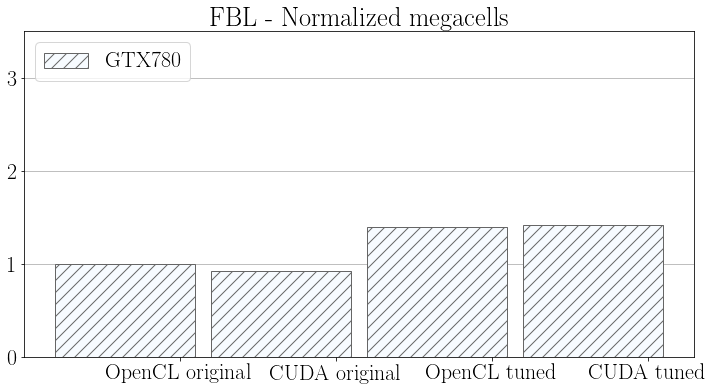

<Figure size 432x288 with 0 Axes>

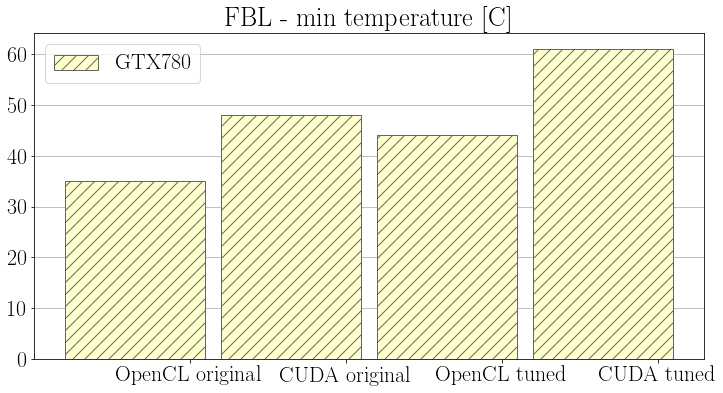

<Figure size 432x288 with 0 Axes>

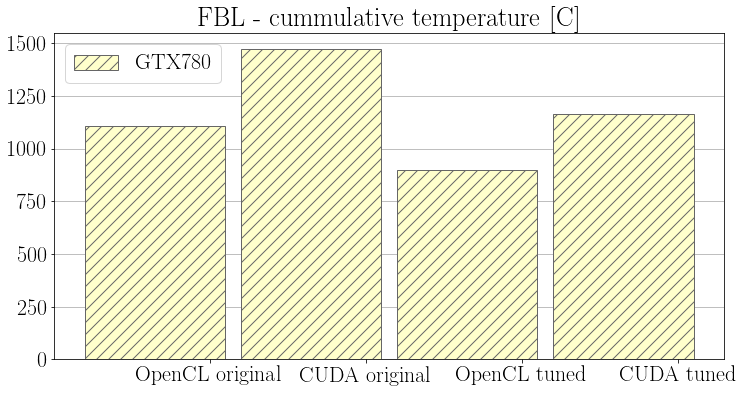

<Figure size 432x288 with 0 Axes>

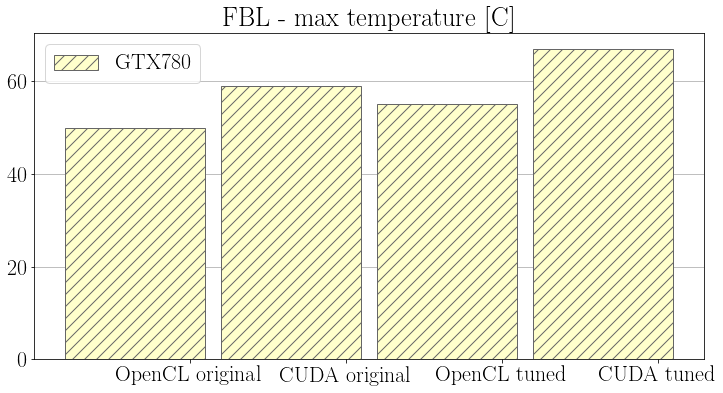

<Figure size 432x288 with 0 Axes>

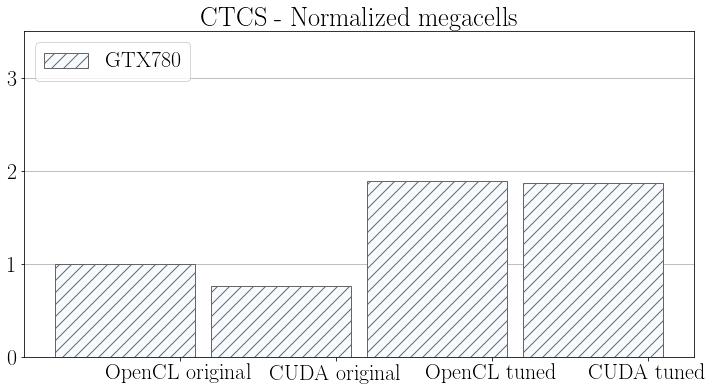

<Figure size 432x288 with 0 Axes>

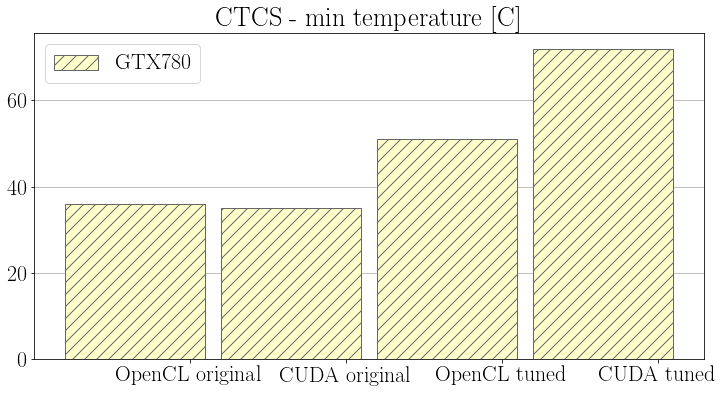

<Figure size 432x288 with 0 Axes>

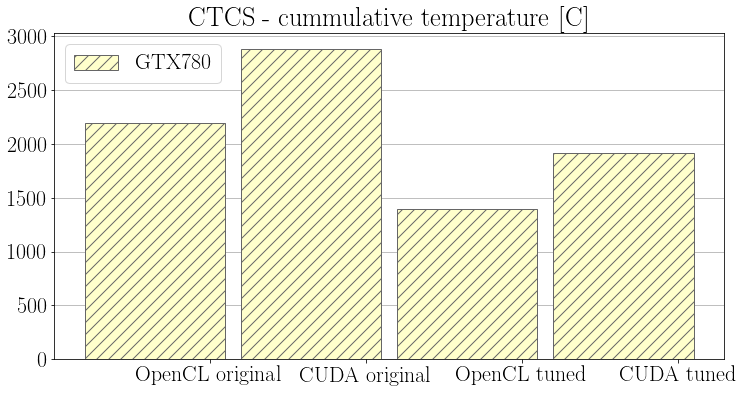

<Figure size 432x288 with 0 Axes>

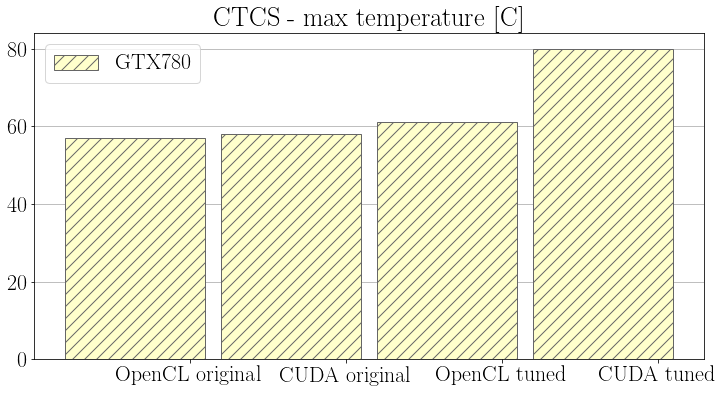

<Figure size 432x288 with 0 Axes>

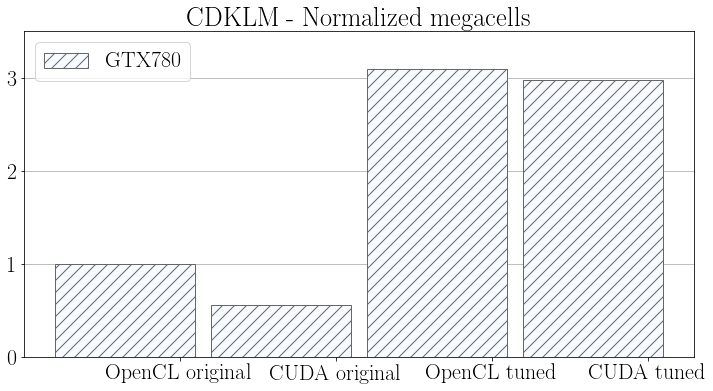

<Figure size 432x288 with 0 Axes>

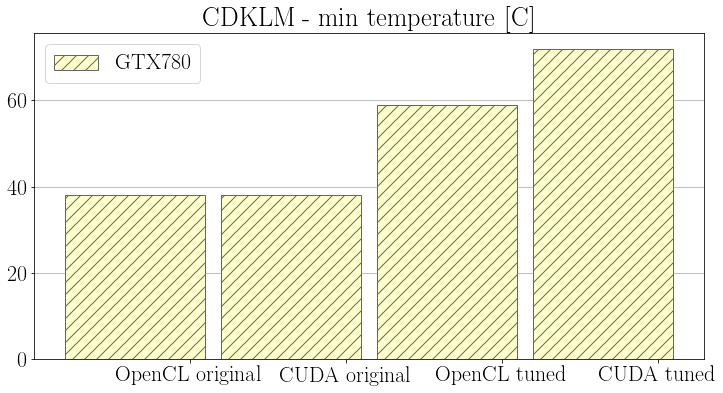

<Figure size 432x288 with 0 Axes>

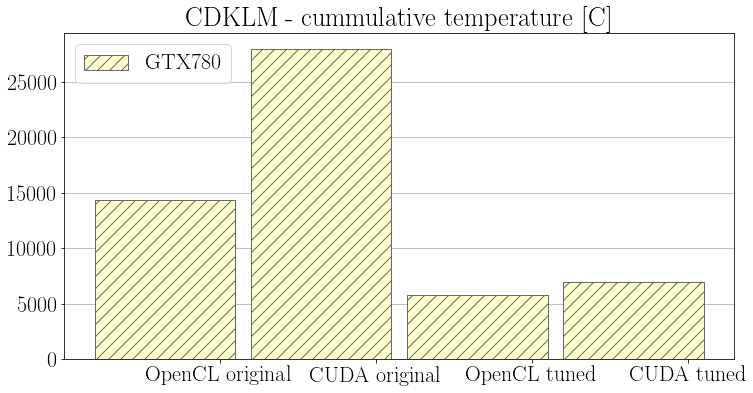

<Figure size 432x288 with 0 Axes>

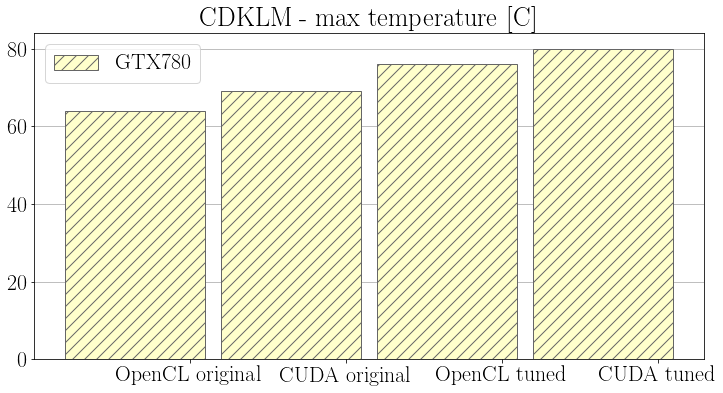

In [66]:
def plot_cuda_vs_opencl_results(opencl_files, cuda_files, key, title, filename=None, normalization=None):
    assert len(opencl_files) == len(cuda_files)
    
    opencl_df, _ = make_df(opencl_files, key)
    cuda_df, _ = make_df(cuda_files, key)
    
    fig = plt.figure()

    fig, ax = plt.subplots(figsize=(12,6))

    num_bars = len(opencl_files)
    bar_width = 0.9 / num_bars
    bar_offset = 0.05

    x = np.arange(4)
    architectures = list(zip(*opencl_files))[1]
    num_architectures = len(architectures)
    
    #print(opencl_df)
    #print(cuda_df)
    
    hatches = ['//', '\\\\', '++', 'xx', '--', '||', '..', '**']
    if (normalization is None):
        cmap = plt.get_cmap("Blues")
    else:
        cmap = plt.get_cmap("YlOrRd")
    colors = cmap(np.arange(num_architectures)/9)
    

    for i, label in enumerate(architectures):
        ocl_values = opencl_df[key + ' ' + label]
        cuda_values = cuda_df[key + ' ' + label]
        
        if (normalization is None):
            n = 1 / ocl_values[0]
        elif (normalization == False):
            n = 1
        else:
            n = 1.0/normalization[i]
        
        ocl_values = ocl_values*n
        cuda_values = cuda_values*n
        
        values = [ocl_values[0], cuda_values[0], ocl_values[-1], cuda_values[-1]]
        #print(values)
        
        ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width, 
               label=label, hatch=hatches[i], color=colors[i], linewidth=1, edgecolor='0.4')

    labels = ["OpenCL original", "CUDA original", "OpenCL tuned", "CUDA tuned"]
    plt.xticks(x, labels)#, rotation='vertical')
    plt.grid(axis='y')
    
    if (normalization is None):
        plt.ylim([0, 3.5])
        plt.yticks([0, 1, 2, 3], [0, 1, 2, 3])

    plt.legend(loc='upper left')
    
    plt.title(title)
    if(filename):
        metadata = {
                    'original_files': json.dumps({"OpenCL": opencl_files, "CUDA": cuda_files}), 
                    'original_data': json.dumps({"OpenCL":opencl_df.to_csv(), "CUDA": cuda_df.to_csv()}), 
                    'created': time.strftime("%Y_%m_%d-%H_%M_%S"),
                    'hostname': socket.gethostname(),
                    'data_key': key
                    }
        if savefigs:
            plt.savefig(filename, dpi=300,format='pdf',
                    transparent=True, pad_inches=0.0, frameon=None, 
                    metadata=metadata)
    
    
#plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, "CDKLM - Normalized megacells", "tuning_cdklm.pdf")
#plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, "CTCS - Normalized megacells", "tuning_ctcs.pdf")
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, megacells_key, "FBL - Normalized megacells", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, min_temperature_key, "FBL - min temperature [C]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, cumsum_temperature_key, "FBL - cummulative temperature [C]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, max_temperature_key, "FBL - max temperature [C]", "tuning_fbl.pdf", normalization=False)

plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, megacells_key, "CTCS - Normalized megacells", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, min_temperature_key, "CTCS - min temperature [C]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, cumsum_temperature_key, "CTCS - cummulative temperature [C]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, max_temperature_key, "CTCS - max temperature [C]", "tuning_fbl.pdf", normalization=False)

plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, megacells_key, "CDKLM - Normalized megacells", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, min_temperature_key, "CDKLM - min temperature [C]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, cumsum_temperature_key, "CDKLM - cummulative temperature [C]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, max_temperature_key, "CDKLM - max temperature [C]", "tuning_fbl.pdf", normalization=False)



In [67]:
savefigs

False

## Plot results

In [73]:
def plot_results(files, title, key, columns=None, labels=None, filename=None):
    df, versions = make_df(files, key)

    num_bars = len(files)
    bar_width = 0.9 / num_bars
    bar_offset = 0.05
    
    if (columns == None):
        columns = np.arange(len(versions))
        
    if (labels == None):
        labels = df['labels'][columns]
    
    assert (len(labels)== len(columns))
        
        
    label_rotation = 0
    fig_width = 12
    alignment = 'center'
    if len(labels) > 4:
        #label_rotation = 15
        #alignment = 'right'
        fig_width = fig_width*len(labels)/4.0
        
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(fig_width,6))

        
    x = np.arange(len(columns))
    architectures = list(zip(*files))[1]
    num_architectures = len(architectures)
        
    hatches = ['//', '\\\\', '++', 'xx', '--', '||', '..', '**']
    cmap = plt.get_cmap("Greens")
    colors = cmap(np.arange(len(architectures))/9)

    for i, label in enumerate(architectures):
        values = df[key + ' ' + label]
        values = values / values[0] #Normalize
        values = values[columns]
        ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width,
               label=label, hatch=hatches[i], color=colors[i], linewidth=1, edgecolor='0.4')

    plt.xticks(x, labels, rotation=label_rotation, horizontalalignment=alignment) #rotation='vertical')
    #for label in axs[0].get_xmajorticklabels() + axs[1].get_xmajorticklabels():
    #    label.set_rotation(30)
    #    label.set_horizontalalignment("right")
    
    plt.grid(axis='y')
    plt.legend(loc='upper left')
    plt.ylim([0, 6])
    plt.yticks([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
    
    plt.title(title)
    if(filename):
        metadata = {
                    'original_files': json.dumps(files), 
                    'original_data': json.dumps(df.to_csv()), 
                    'created': time.strftime("%Y_%m_%d-%H_%M_%S"),
                    'hostname': socket.gethostname(),
                    'data_key': key
                    }
        if savefigs:
            plt.savefig(filename, dpi=300,format='pdf',
                    transparent=True, pad_inches=0.0, frameon=None, 
                    metadata=metadata)


<Figure size 432x288 with 0 Axes>

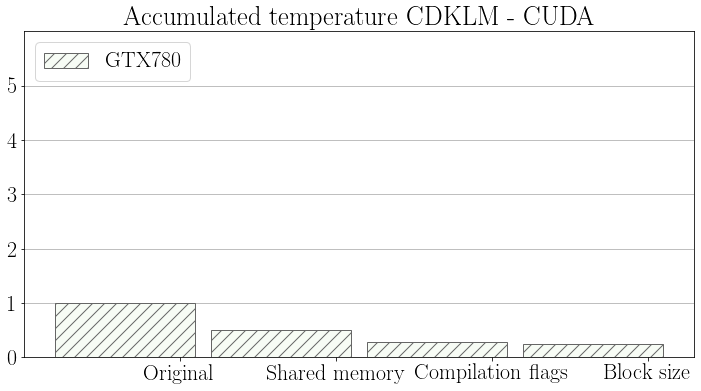

<Figure size 432x288 with 0 Axes>

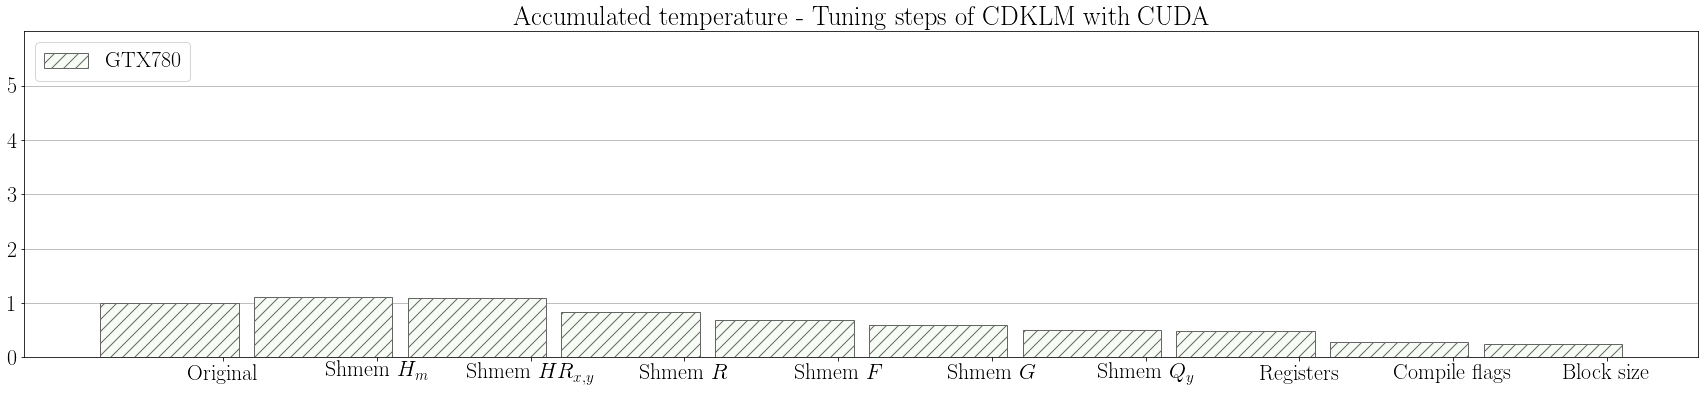

<Figure size 432x288 with 0 Axes>

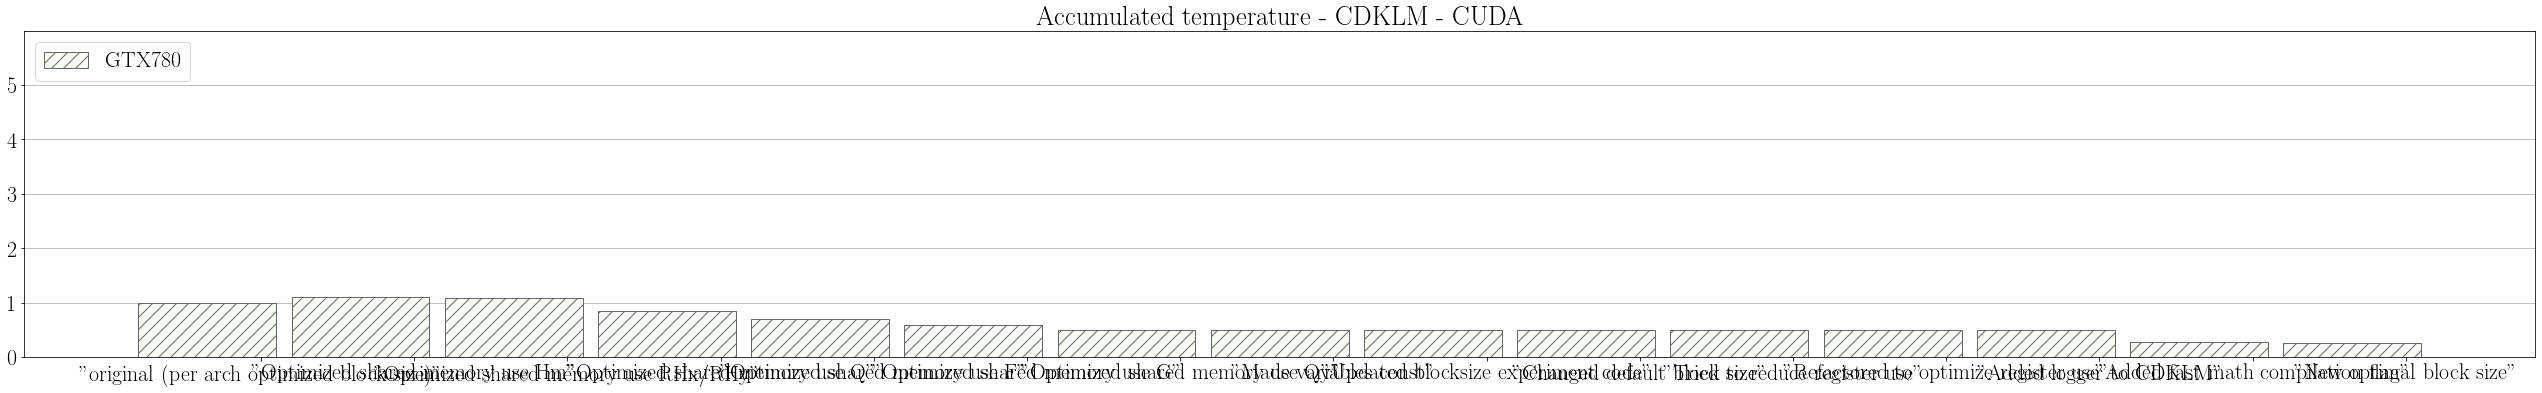

<Figure size 432x288 with 0 Axes>

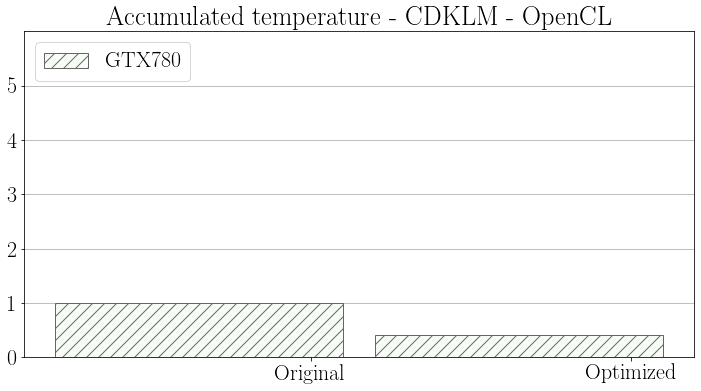

In [74]:
plot_results(cdklm_cuda, "Accumulated temperature CDKLM - CUDA", key=cumsum_temperature_key, 
             columns=[0, 6, 13, 14], 
             labels=["Original", "Shared memory", "Compilation flags", "Block size"], 
             filename="cuda_cdklm.pdf")

shmem = "Shmem "
plot_results(cdklm_cuda, "Accumulated temperature - Tuning steps of CDKLM with CUDA", 
             key=cumsum_temperature_key,
             columns=[0,1,2,3,4,5,6, 12, 13, 14],
             labels=["Original", 
                     shmem + "$H_m$",
                     shmem + "$HR_{x,y}$",
                     shmem + "$R$",
                     shmem + "$F$",
                     shmem + "$G$",
                     shmem + "$Q_y$",
                     "Registers",
                     "Compile flags", 
                     "Block size"], 
             filename="cuda_cdklm_tuning.pdf")

plot_results(cdklm_cuda, "Accumulated temperature - CDKLM - CUDA", 
             key=cumsum_temperature_key,
             columns=None, labels=None, 
             filename="cuda_cdklm_all.pdf")

plot_results(cdklm_opencl, "Accumulated temperature - CDKLM - OpenCL", 
             key=cumsum_temperature_key, 
             labels=["Original", "Optimized"], 
             filename="opencl_cdklm.pdf")

<Figure size 432x288 with 0 Axes>

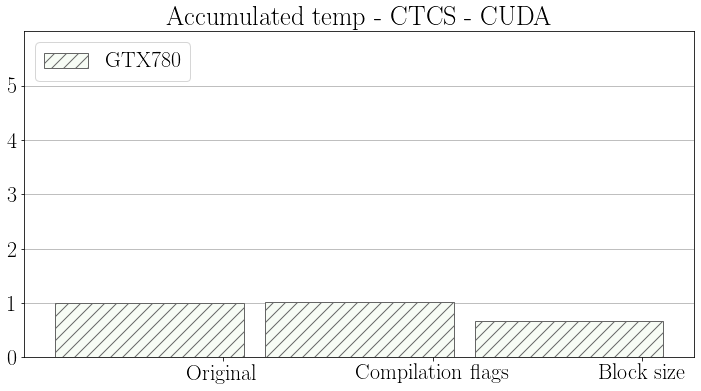

<Figure size 432x288 with 0 Axes>

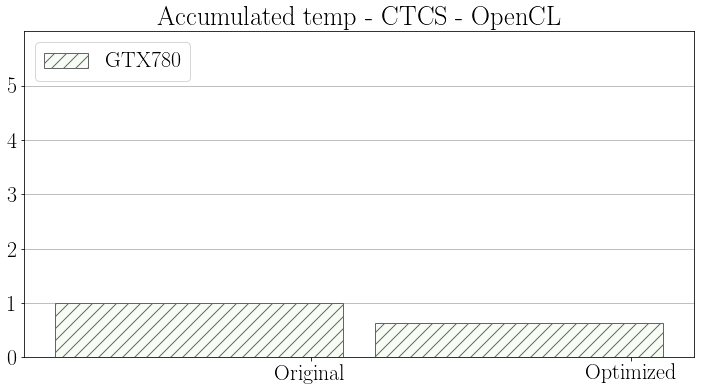

In [75]:
plot_results(ctcs_cuda, "Accumulated temp - CTCS - CUDA", 
             key=cumsum_temperature_key,
             columns=[0, 7, 8], labels=["Original", "Compilation flags", "Block size"], filename="cuda_ctcs.pdf")


plot_results(ctcs_opencl, "Accumulated temp - CTCS - OpenCL", 
             key=cumsum_temperature_key,
             labels=["Original", "Optimized"], filename="opencl_ctcs.pdf")

<Figure size 432x288 with 0 Axes>

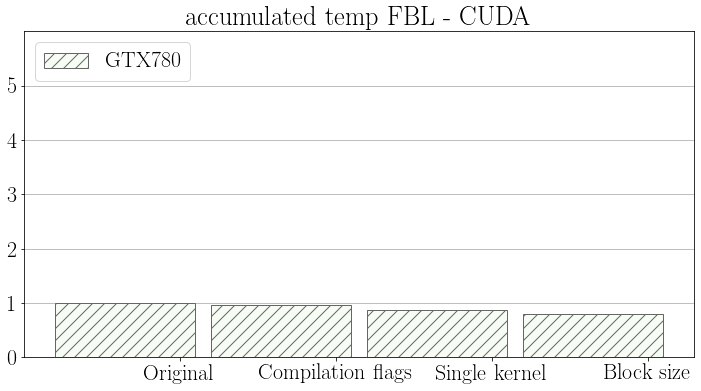

<Figure size 432x288 with 0 Axes>

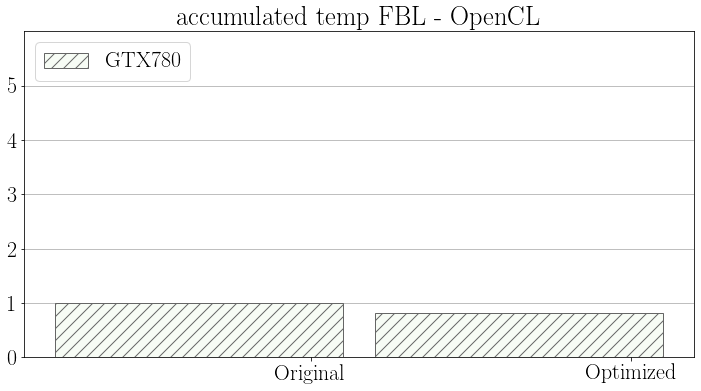

In [76]:
plot_results(fbl_cuda, "accumulated temp FBL - CUDA", 
             key=cumsum_temperature_key,
             labels=["Original", "Compilation flags", "Single kernel", "Block size"], filename="cuda_fbl.pdf")


plot_results(fbl_opencl, "accumulated temp FBL - OpenCL", 
             key=cumsum_temperature_key,
             labels=["Original", "Optimized"], filename="opencl_fbl.pdf")

In [77]:
np.__version__


'1.17.0'